## Import Library

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#EDA
import nltk
from langdetect import detect
from googletrans import Translator
from nltk.util import ngrams
from nltk.corpus import stopwords
import wordcloud
import yake
from rake_nltk import Rake
# preprcessing
import contractions
from string import punctuation
from unidecode import unidecode
from nltk.tokenize import word_tokenize,sent_tokenize,WhitespaceTokenizer,regexp_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer,PorterStemmer,SnowballStemmer
from autocorrect import Speller
from textblob import TextBlob
import contractions

from collections import Counter

#ModelTraining
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB,GaussianNB
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.svm import SVC

# Deep learning model
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

# file handing
import json
import pickle

import warnings 
warnings.filterwarnings("ignore")

## Problem Statement

In [ ]:
To Detect given email spam or ham

# Data gathering

In [74]:
df=pd.read_csv("spam_ham_dataset.csv",usecols=["label",'text',"label_num"])
df=df.head(2000)

## Preprocessing

In [55]:
df.text

0       Subject: enron methanol ; meter # : 988291\r\n...
1       Subject: hpl nom for january 9 , 2001\r\n( see...
2       Subject: neon retreat\r\nho ho ho , we ' re ar...
3       Subject: photoshop , windows , office . cheap ...
4       Subject: re : indian springs\r\nthis deal is t...
                              ...                        
1995    Subject: re : saudi arabia\r\ndaren :\r\ni ' l...
1996    Subject: july 2000 co - owner ' s volumes\r\nj...
1997    Subject: greatly improve your stamina\r\ni ' v...
1998    Subject: calpine daily gas nomination\r\n> >\r...
1999    Subject: king ranch\r\nstella ,\r\nit is very ...
Name: text, Length: 2000, dtype: object

In [56]:
# 1.remove Whitespaces,new lines,symbols
def remove_spaces(data):
    clean_text=data.replace("\t"," ").replace("\n"," ").replace("\\"," ")
    return clean_text
#2.Contraction Mapping
def expand_text1(data):
    expanded_text=contractions.fix(data)
    return expanded_text

# 3.Handling Ascented Character
def handling_ascented(data):
    fixed_data=unidecode(data)
    return fixed_data
stopwords_list=stopwords.words("english")
stopwords_list.append("subject")               # Domain specific stopword
# 4.clean text
def text_cleaning(data):
    tokens=word_tokenize(data)
    cleaned_text=[word.lower() for word in tokens if (word.lower() not in stopwords_list) and (word not in punctuation) and (len(word)>2) and (word.isalpha())]
    return cleaned_text
#5. lemmatizer
def lemmatized_text(data):
    lemmatizer=WordNetLemmatizer()
    final_data=[]
    for word in data:
        final_text=lemmatizer.lemmatize(word)
        final_data.append(final_text)
    return " ".join(final_data)

In [57]:
clean_text=df.text.apply(remove_spaces)
clean_text=clean_text.apply(expand_text1)
clean_text=clean_text.apply(handling_ascented)
clean_text=clean_text.apply(text_cleaning)
clean_text=clean_text.apply(lemmatized_text)
clean_text

0       enron methanol meter follow note gave monday p...
1       hpl nom january see attached file hplnol xl hp...
2       neon retreat around wonderful time year neon l...
3       photoshop window office cheap main trending ab...
4       indian spring deal book teco pvr revenue under...
                              ...                        
1995    saudi arabia daren follow sure know likely sto...
1996    july owner volume july lst owner volume koch t...
1997    greatly improve stamen using product month inc...
1998    calpine daily gas nomination ricky archer fuel...
1999    king ranch stella important king ranch accurat...
Name: text, Length: 2000, dtype: object

In [75]:
df["clean_text"]=clean_text
df

,label,text,label_num,clean_text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,enron methanol meter follow note gave monday p...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,hpl nom january see attached file hplnol xl hp...
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,neon retreat around wonderful time year neon l...
3,spam,"Subject: photoshop , windows , office . cheap ...",1,photoshop window office cheap main trending ab...
4,ham,Subject: re : indian springs\r\nthis deal is t...,0,indian spring deal book teco pvr revenue under...
...,...,...,...,...
1995,ham,Subject: re : saudi arabia\r\ndaren :\r\ni ' l...,0,saudi arabia daren follow sure know likely sto...
1996,ham,Subject: july 2000 co - owner ' s volumes\r\nj...,0,july owner volume july lst owner volume koch t...
1997,spam,Subject: greatly improve your stamina\r\ni ' v...,1,greatly improve stamen using product month inc...
1998,ham,Subject: calpine daily gas nomination\r\n> >\r...,0,calpine daily gas nomination ricky archer fuel...


## EDA

### 1.Language Detection

In [59]:
language=detect(df.clean_text[0])
language

'en'

In [76]:

language=[]
list1=clean_text.to_list()
for text1 in list1:
    try:
        lang=detect(text1)
        language.append(lang)
    except:
        language.append("No text")
        


In [77]:
df["language"]=language

In [88]:
df["language"].value_counts()

language
en    1885
ca      32
nl      17
fr      13
it      12
sv       8
af       5
ro       4
da       4
es       4
so       2
no       2
lt       1
de       1
pt       1
cs       1
Name: count, dtype: int64

In [85]:
#Detect rows with no text
np.where(df["language"]=="No text")

(array([ 154,  182,  296,  363, 1130, 1279, 1369, 1508], dtype=int64),)

In [87]:
#drop the rows with no data
df.drop([ 154,  182,  296,  363, 1130, 1279, 1369, 1508],axis=0,inplace=True)

## Language Translator

In [90]:
# def lang_translator(data):
#     translator=Translator()
#     translated_text=translator.translate(data,dest="en")
#     return translated_text.text
# df["Translated_text"]=df.clean_text.apply(lang_translator)

## 2.Ngrams

In [31]:
# 2.1 unigram
def ngram_extractor(data,ngram_range):
    tokens=word_tokenize(data)
    ngram =ngrams(tokens,ngram_range)
    ngram_list=[]
    for ngram1 in ngram:
        ngram_list.append(" ".join(ngram1))
    return ngram_list
list_unigram=df["clean_text"].apply(lambda x:ngram_extractor(x,1))
final_unigram=[]
for unigram in list_unigram:
    final_unigram.extend(unigram)
count=Counter(final_unigram)
count.most_common(25)

[('ect', 13908),
 ('hou', 7289),
 ('enron', 6555),
 ('com', 3709),
 ('deal', 3635),
 ('please', 3198),
 ('gas', 3036),
 ('meter', 2716),
 ('hpl', 2318),
 ('daren', 1901),
 ('thanks', 1900),
 ('need', 1846),
 ('corp', 1776),
 ('volume', 1690),
 ('know', 1612),
 ('day', 1549),
 ('price', 1524),
 ('new', 1435),
 ('company', 1429),
 ('may', 1382),
 ('mmbtu', 1349),
 ('get', 1320),
 ('forwarded', 1297),
 ('http', 1242),
 ('see', 1212)]

In [41]:
## 2.2 bigram
list_bigram=df["clean_text"].apply(lambda x:ngram_extractor(x,2))
final_bigram=[]
for bigram in list_bigram:
    final_bigram.extend(bigram)
count=Counter(final_bigram)
count.most_common(25)

[('hou ect', 7226),
 ('ect ect', 6341),
 ('enron enron', 1447),
 ('corp enron', 1214),
 ('let know', 1003),
 ('daren farmer', 933),
 ('enron com', 831),
 ('see attached', 572),
 ('farmer hou', 563),
 ('http www', 538),
 ('attached file', 511),
 ('please let', 461),
 ('original message', 446),
 ('enron hpl', 432),
 ('pec pec', 357),
 ('teco tap', 333),
 ('north america', 325),
 ('ami chokshi', 308),
 ('gas daily', 305),
 ('ect enron', 304),
 ('nbsp nbsp', 297),
 ('robert cotten', 289),
 ('enron north', 287),
 ('vance taylor', 282),
 ('would like', 281)]

In [42]:
## 2.3 trigram 
list_trigram=df["clean_text"].apply(lambda x:ngram_extractor(x,3))
final_trigram=[]
for trigram in list_trigram:
    final_trigram.extend(trigram)
count=Counter(final_trigram)
count.most_common(25)

[('hou ect ect', 6271),
 ('corp enron enron', 920),
 ('daren farmer hou', 563),
 ('farmer hou ect', 563),
 ('see attached file', 490),
 ('please let know', 437),
 ('enron north america', 283),
 ('ect daren farmer', 271),
 ('north america corp', 255),
 ('robert cotten hou', 249),
 ('cotten hou ect', 249),
 ('hou ect enron', 247),
 ('nbsp nbsp nbsp', 246),
 ('pat clynes corp', 232),
 ('clynes corp enron', 232),
 ('ect ect daren', 227),
 ('ect pat clynes', 211),
 ('ami chokshi corp', 211),
 ('chokshi corp enron', 211),
 ('teco tap enron', 210),
 ('smith hou ect', 210),
 ('ect ect pat', 203),
 ('melissa graf hou', 196),
 ('graf hou ect', 196),
 ('ect ect robert', 196)]

## 2.Wordcloud

In [46]:
from wordcloud import WordCloud

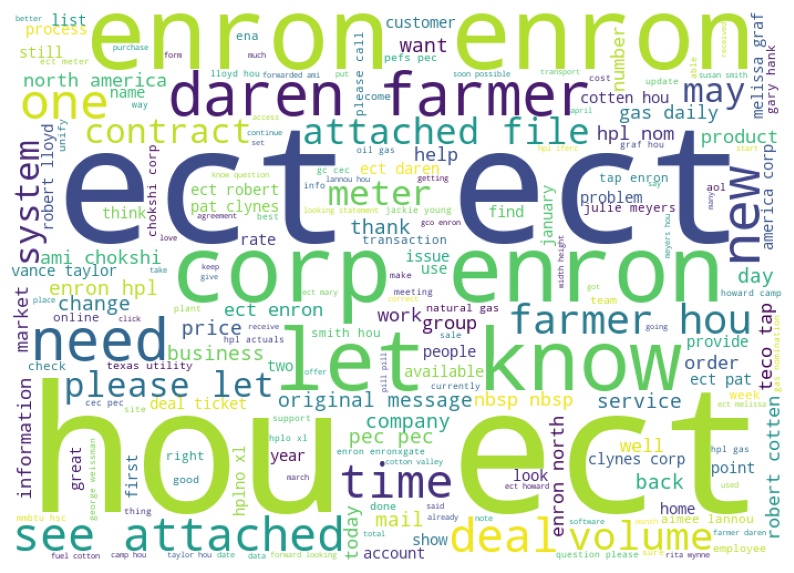

In [47]:
def wordcloud_genereator(data,column):
    df_=data[column].str.cat(sep=" ")
    wordcloud1=WordCloud(width=700,height=500,background_color="white").generate(df_)
    plt.figure(figsize=(10,16))
    plt.imshow(wordcloud1)
    plt.axis("off")
    plt.show()
wordcloud_genereator(df,"clean_text")

## Keyphrase Extraction

### Rake Extrator

In [91]:
def rake_extractor(data):
    keyword_extractor=Rake()
    keyword_extractor.extract_keywords_from_text(data)
    return keyword_extractor.get_ranked_phrases()
rake_keywords=df.clean_text.apply(rake_extractor)
rake_keywords

0       [enron methanol meter follow note gave monday ...
1       [hpl nom january see attached file hplnol xl h...
2       [neon retreat around wonderful time year neon ...
3       [photoshop window office cheap main trending a...
4       [indian spring deal book teco pvr revenue unde...
                              ...                        
1995    [saudi arabia daren follow sure know likely st...
1996    [july owner volume july lst owner volume koch ...
1997    [greatly improve stamen using product month in...
1998    [calpine daily gas nomination ricky archer fue...
1999    [king ranch stella important king ranch accura...
Name: clean_text, Length: 1992, dtype: object

In [92]:
final_keywords=[]
for kw in rake_keywords:
    final_keywords.extend(kw)
count=Counter(final_keywords)
count.most_common(100)

[('hpl nom may see attached file hplno xl hplno xl', 13),
 ('hpl nom march see attached file hplno xl hplno xl', 12),
 ('hpl nom june see attached file hplo xl hplo xl', 8),
 ('hpl nom august see attached file hplo xl hplo xl', 7),
 ('hpl nom april see attached file hplno xl hplno xl', 7),
 ('hpl nom january see attached file hplnol xl hplnol xl', 6),
 ('calpine daily gas nomination ricky archer fuel supply louisiana suite houston texas direct fax calpine daily gas nomination doc',
  6),
 ('hpl nom july see attached file hplo xl hplo xl', 5),
 ('noms actual flow agree nomination eileen ponton david avila lsp enserch charlie stone texas utility melissa jones texas utility hpl scheduling enron com liz bellamy enron com noms actual flow nom mcf mmbtu btu',
  4),
 ('hpl nom december see attached file hplnl xl hplnl xl', 4),
 ('enron hpl actuals january teco tap enron', 4),
 ('enron hpl actuals august teco tap enron hpl gas daily hpl lsk enron', 3),
 ('enron hpl actuals october teco tap enr

## Yake Extractor

In [94]:
def yake_extractor(data):
    keyword_extractor=yake.KeywordExtractor()
    keyword=keyword_extractor.extract_keywords(data)
    keyword_list=[]
    for kw in keyword:
        keyword_list.append(kw[0])
    return keyword_list
keywords=df.clean_text.apply(yake_extractor)

In [95]:
yake_keywords=[]
for kw in keywords:
    yake_keywords.extend(kw)
count=Counter(yake_keywords)
count.most_common(10)

[('hou ect ect', 263),
 ('attached file', 152),
 ('farmer hou ect', 135),
 ('hpl', 131),
 ('attached', 130),
 ('file', 123),
 ('nom', 102),
 ('hpl nom', 93),
 ('ect ect', 82),
 ('daren farmer hou', 82)]

## Data Splitting

In [97]:
x=df["clean_text"]
y=df["label_num"]
y

0       0
1       0
2       0
3       1
4       0
       ..
1995    0
1996    0
1997    1
1998    0
1999    0
Name: label_num, Length: 1992, dtype: int64

In [98]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=22,stratify=y)

## Feature Engineering

### 1.Count Vectorizer

In [101]:
count_vectorizer=CountVectorizer(max_df=1,max_features=1000)
x_train_count=count_vectorizer.fit_transform(x_train).A
x_train_df=pd.DataFrame(x_train_count,columns=count_vectorizer.get_feature_names_out())
x_test_count=count_vectorizer.transform(x_test).A
x_test_df=pd.DataFrame(x_test_count,columns=count_vectorizer.get_feature_names_out())
x_test_df

,abacustech,abdul,abdv,abhorred,accountonline,accredit,accum,acf,acquisitive,acutrim,...,xcelerator,xclmdz,xpp,yea,ygcy,yokel,zipusx,zmedabsd,zorps,zwiers
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Model Training

### 1.MUltinomial Naive Bayes Model

In [102]:
mnb_nb=MultinomialNB()
mnb_nb.fit(x_train_df,y_train)

MultinomialNB()

In [104]:
# Train data Evaluation
y_train_pred=mnb_nb.predict(x_train_df)
cnf_mat=confusion_matrix(y_train_pred,y_train)
print("Confusion matrics :\n",cnf_mat)
acc=accuracy_score(y_train_pred,y_train)
print("Accuracy Score :",acc)
clf_rep=classification_report(y_train_pred,y_train)
print("CLassification Report :\n",clf_rep)

Confusion matrics :
 [[1149  318]
 [   0  126]]
Accuracy Score : 0.800376647834275
CLassification Report :
               precision    recall  f1-score   support

           0       1.00      0.78      0.88      1467
           1       0.28      1.00      0.44       126

    accuracy                           0.80      1593
   macro avg       0.64      0.89      0.66      1593
weighted avg       0.94      0.80      0.84      1593



In [105]:
# Test data Evaluation
y_pred=mnb_nb.predict(x_test_df)
cnf_mat=confusion_matrix(y_pred,y_test)
print("Confusion matrics :\n",cnf_mat)
acc=accuracy_score(y_pred,y_test)
print("Accuracy Score :",acc)
clf_rep=classification_report(y_pred,y_test)
print("CLassification Report :\n",clf_rep)

Confusion matrics :
 [[286  90]
 [  2  21]]
Accuracy Score : 0.7694235588972431
CLassification Report :
               precision    recall  f1-score   support

           0       0.99      0.76      0.86       376
           1       0.19      0.91      0.31        23

    accuracy                           0.77       399
   macro avg       0.59      0.84      0.59       399
weighted avg       0.95      0.77      0.83       399



### 2.SVM Classifier

In [107]:
svc=SVC()
svc.fit(x_train_df,y_train)

SVC()

In [108]:
# Train data Evaluation
y_train_pred=svc.predict(x_train_df)
cnf_mat=confusion_matrix(y_train_pred,y_train)
print("Confusion matrics :\n",cnf_mat)
acc=accuracy_score(y_train_pred,y_train)
print("Accuracy Score :",acc)
clf_rep=classification_report(y_train_pred,y_train)
print("CLassification Report :\n",clf_rep)

Confusion matrics :
 [[1149  380]
 [   0   64]]
Accuracy Score : 0.7614563716258631
CLassification Report :
               precision    recall  f1-score   support

           0       1.00      0.75      0.86      1529
           1       0.14      1.00      0.25        64

    accuracy                           0.76      1593
   macro avg       0.57      0.88      0.56      1593
weighted avg       0.97      0.76      0.83      1593



In [109]:
# Test data Evaluation
y_pred=svc.predict(x_test_df)
cnf_mat=confusion_matrix(y_pred,y_test)
print("Confusion matrics :\n",cnf_mat)
acc=accuracy_score(y_pred,y_test)
print("Accuracy Score :",acc)
clf_rep=classification_report(y_pred,y_test)
print("CLassification Report :\n",clf_rep)

Confusion matrics :
 [[288 107]
 [  0   4]]
Accuracy Score : 0.731829573934837
CLassification Report :
               precision    recall  f1-score   support

           0       1.00      0.73      0.84       395
           1       0.04      1.00      0.07         4

    accuracy                           0.73       399
   macro avg       0.52      0.86      0.46       399
weighted avg       0.99      0.73      0.84       399



## 2.TF-IDF vectorizer

In [110]:
tfidf_vectorizer=TfidfVectorizer(max_df=1,max_features=1000)
x_train_tf=tfidf_vectorizer.fit_transform(x_train).A
x_train_tf=pd.DataFrame(x_train_tf,columns=tfidf_vectorizer.get_feature_names_out())
x_test_tf=tfidf_vectorizer.transform(x_test).A
x_test_tf=pd.DataFrame(x_test_tf,columns=tfidf_vectorizer.get_feature_names_out())
x_test_tf

,abacustech,abdul,abdv,abhorred,accountonline,accredit,accum,acf,acquisitive,acutrim,...,xcelerator,xclmdz,xpp,yea,ygcy,yokel,zipusx,zmedabsd,zorps,zwiers
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
## 1.Multinomial naive bayes
mnb_nb=MultinomialNB()
mnb_nb.fit(x_train_tf,y_train)

MultinomialNB()

In [112]:
# Train data Evaluation
y_train_pred=mnb_nb.predict(x_train_tf)
cnf_mat=confusion_matrix(y_train_pred,y_train)
print("Confusion matrics :\n",cnf_mat)
acc=accuracy_score(y_train_pred,y_train)
print("Accuracy Score :",acc)
clf_rep=classification_report(y_train_pred,y_train)
print("CLassification Report :\n",clf_rep)

Confusion matrics :
 [[1149  423]
 [   0   21]]
Accuracy Score : 0.7344632768361582
CLassification Report :
               precision    recall  f1-score   support

           0       1.00      0.73      0.84      1572
           1       0.05      1.00      0.09        21

    accuracy                           0.73      1593
   macro avg       0.52      0.87      0.47      1593
weighted avg       0.99      0.73      0.83      1593



In [113]:
# Test data Evaluation
y_pred=mnb_nb.predict(x_test_tf)
cnf_mat=confusion_matrix(y_pred,y_test)
print("Confusion matrics :\n",cnf_mat)
acc=accuracy_score(y_pred,y_test)
print("Accuracy Score :",acc)
clf_rep=classification_report(y_pred,y_test)
print("CLassification Report :\n",clf_rep)

Confusion matrics :
 [[288 110]
 [  0   1]]
Accuracy Score : 0.7243107769423559
CLassification Report :
               precision    recall  f1-score   support

           0       1.00      0.72      0.84       398
           1       0.01      1.00      0.02         1

    accuracy                           0.72       399
   macro avg       0.50      0.86      0.43       399
weighted avg       1.00      0.72      0.84       399



In [114]:
## 2.SVC
svc=SVC()
svc.fit(x_train_tf,y_train)

SVC()

In [115]:
# Train data Evaluation
y_train_pred=svc.predict(x_train_tf)
cnf_mat=confusion_matrix(y_train_pred,y_train)
print("Confusion matrics :\n",cnf_mat)
acc=accuracy_score(y_train_pred,y_train)
print("Accuracy Score :",acc)
clf_rep=classification_report(y_train_pred,y_train)
print("CLassification Report :\n",clf_rep)

Confusion matrics :
 [[1149  318]
 [   0  126]]
Accuracy Score : 0.800376647834275
CLassification Report :
               precision    recall  f1-score   support

           0       1.00      0.78      0.88      1467
           1       0.28      1.00      0.44       126

    accuracy                           0.80      1593
   macro avg       0.64      0.89      0.66      1593
weighted avg       0.94      0.80      0.84      1593



In [116]:
# Test data Evaluation
y_pred=svc.predict(x_test_tf)
cnf_mat=confusion_matrix(y_pred,y_test)
print("Confusion matrics :\n",cnf_mat)
acc=accuracy_score(y_pred,y_test)
print("Accuracy Score :",acc)
clf_rep=classification_report(y_pred,y_test)
print("CLassification Report :\n",clf_rep)

Confusion matrics :
 [[286 104]
 [  2   7]]
Accuracy Score : 0.7343358395989975
CLassification Report :
               precision    recall  f1-score   support

           0       0.99      0.73      0.84       390
           1       0.06      0.78      0.12         9

    accuracy                           0.73       399
   macro avg       0.53      0.76      0.48       399
weighted avg       0.97      0.73      0.83       399



# 3.Word2vec

In [166]:
sent_train=x_train.to_list()
splitted_sent_train=[sen.split() for sen in sent_train]
sent_test=x_test.to_list()
splitted_sent_test=[sen.split() for sen in sent_test]
splitted_sent_test

[['allocation',
  'attached',
  'allocation',
  'texas',
  'operation',
  'let',
  'know',
  'question'],
 ['deer',
  'park',
  'railroad',
  'crossing',
  'line',
  'following',
  'meter',
  'affected',
  'section',
  'outage',
  'planned',
  'april',
  'georgia',
  'gulf',
  'phillips',
  'pasadena',
  'albemarle',
  'air',
  'product',
  'pasadena',
  'crown',
  'refinery',
  'west',
  'station',
  'crown',
  'city',
  'gate',
  'meter',
  'flowing',
  'march',
  'two',
  'listed',
  'memo',
  'albemarle',
  'air',
  'product',
  'pasadena',
  'able',
  'feed',
  'hpl',
  'outage',
  'update',
  'thing',
  'change',
  'thanks',
  'gary',
  'forwarded',
  'gary',
  'hank',
  'hou',
  'ect',
  'william',
  'cosby',
  'enron',
  'sent',
  'william',
  'cosby',
  'enron',
  'gary',
  'hank',
  'hou',
  'ect',
  'ect',
  'deer',
  'park',
  'railroad',
  'crossing',
  'line',
  'gary',
  'mainline',
  'valve',
  'closed',
  'line',
  'follows',
  'crown',
  'street',
  'end',
  'line',
 

In [164]:
Word2vec_model=Word2Vec(splitted_sent_train,min_count=2,window=3)
Word2vec_model

In [165]:
# Save pickle file
with open("word2vec_model.pkl","wb") as f:
    pickle.dump(Word2vec_model,f)

In [119]:
#Document Nemerical Format
# create neumerical data of document
def vectorizer(list_of_docs,model):
    feature=[]
    for rew in list_of_docs:
        zero_vector=np.zeros(model.vector_size)
        vectors=[]
        for word in rew:
            try:
                word in model.wv
                vectors.append(model.wv[word])
            except KeyError:
                continue
        if vectors:
            vector1=np.asarray(vectors)
            avg_vec=vector1.mean(axis=0)
            feature.append(avg_vec)
        else:
            feature.append(zero_vector)
    return feature

In [120]:
vectorized_docs=vectorizer(splitted_sent_train,Word2vec_model)
len(vectorized_docs[0])

100

In [124]:
word2vec_train=np.array(vectorized_docs)
word2vec_train

array([[-0.18716078, -0.17856333, -0.62659252, ..., -0.85225713,
         0.79273826,  0.13093194],
       [ 0.04254027,  0.13297056, -0.08928662, ..., -0.27829224,
         0.06898881,  0.0352332 ],
       [-0.11304626,  0.4357937 ,  0.25648791, ..., -0.86496246,
         0.21436219,  0.36966717],
       ...,
       [-0.44687197,  0.62961608,  0.83697414, ..., -1.37712884,
         0.41391656,  0.86306608],
       [ 0.01141917,  0.07505275, -0.01365004, ..., -0.14508964,
         0.02715587,  0.02325985],
       [ 0.03628287,  0.21580876, -0.02928945, ..., -0.39310092,
         0.07535155,  0.09387564]])

In [122]:
vectorized_docs_test=vectorizer(splitted_sent_test,Word2vec_model)
len(vectorized_docs_test[0])

100

In [123]:
word2vec_test=np.array(vectorized_docs_test)
word2vec_test

array([[ 0.3043806 ,  0.41904572, -0.39067462, ..., -0.64466763,
         0.12886271,  0.07200507],
       [-0.10388179,  0.33748332,  0.14677982, ..., -0.67201567,
         0.22575913,  0.23953773],
       [ 0.06253264,  0.2523874 , -0.06067241, ..., -0.46240661,
         0.05629019,  0.04218927],
       ...,
       [ 0.1902307 ,  0.3789978 , -0.19975656, ..., -0.57206303,
         0.05223974,  0.06593349],
       [-0.33468801,  0.22688705, -0.00493741, ..., -0.86975259,
         0.60114199,  0.19602902],
       [ 0.10881582,  0.34680563, -0.18341076, ..., -0.53859091,
         0.14598039,  0.06694373]])

## Model Training

In [125]:
## MultinomialNaive Baues Doesent work due to negative values if dataframe

## 1.Gaussian Naive Bayes

In [128]:
Gnb_model=GaussianNB()
Gnb_model.fit(word2vec_train,y_train)

GaussianNB()

In [134]:
# Train Data Evaluation
y_pred_train=Gnb_model.predict(word2vec_train)
acc_score=accuracy_score(y_pred_train,y_train)
print("Accuracy Score  :",acc_score)
cnf_matrix=confusion_matrix(y_pred_train,y_train)
print("Confusion Matrics  :\n",cnf_matrix)
clf_rep=classification_report(y_pred_train,y_train)
print("Classification report  :\n",clf_rep)

Accuracy Score  : 0.8179535467671061
Confusion Matrics  :
 [[877  18]
 [272 426]]
Classification report  :
               precision    recall  f1-score   support

           0       0.76      0.98      0.86       895
           1       0.96      0.61      0.75       698

    accuracy                           0.82      1593
   macro avg       0.86      0.80      0.80      1593
weighted avg       0.85      0.82      0.81      1593



In [135]:
# test Data Evaluation
y_pred=Gnb_model.predict(word2vec_test)
acc_score=accuracy_score(y_pred,y_test)
print("Accuracy Score  :",acc_score)
cnf_matrix=confusion_matrix(y_pred,y_test)
print("Confusion Matrics  :\n",cnf_matrix)
clf_rep=classification_report(y_pred,y_test)
print("Classification report  :\n",clf_rep)

Accuracy Score  : 0.8245614035087719
Confusion Matrics  :
 [[224   6]
 [ 64 105]]
Classification report  :
               precision    recall  f1-score   support

           0       0.78      0.97      0.86       230
           1       0.95      0.62      0.75       169

    accuracy                           0.82       399
   macro avg       0.86      0.80      0.81       399
weighted avg       0.85      0.82      0.82       399



### 2.SVC

In [158]:
svc=SVC()
svc.fit(word2vec_train,y_train)

SVC()

In [159]:
# Train Data Evaluation
y_pred_train=svc.predict(word2vec_train)
acc_score=accuracy_score(y_train,y_pred_train)
print("Accuracy Score  :",acc_score)
cnf_matrix=confusion_matrix(y_train,y_pred_train)
print("Confusion Matrics  :\n",cnf_matrix)
clf_rep=classification_report(y_train,y_pred_train)
print("Classification report  :\n",clf_rep)

Accuracy Score  : 0.9221594475831764
Confusion Matrics  :
 [[1052   97]
 [  27  417]]
Classification report  :
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      1149
           1       0.81      0.94      0.87       444

    accuracy                           0.92      1593
   macro avg       0.89      0.93      0.91      1593
weighted avg       0.93      0.92      0.92      1593



In [160]:
# test Data Evaluation
y_pred=svc.predict(word2vec_test)
acc_score=accuracy_score(y_pred,y_test)
print("Accuracy Score  :",acc_score)
cnf_matrix=confusion_matrix(y_pred,y_test)
print("Confusion Matrics  :\n",cnf_matrix)
clf_rep=classification_report(y_pred,y_test)
print("Classification report  :\n",clf_rep)

Accuracy Score  : 0.9122807017543859
Confusion Matrics  :
 [[264  11]
 [ 24 100]]
Classification report  :
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       275
           1       0.90      0.81      0.85       124

    accuracy                           0.91       399
   macro avg       0.91      0.88      0.89       399
weighted avg       0.91      0.91      0.91       399



In [163]:
# considering good model 
with open("svm_model.pkl","wb") as f:
    pickle.dump(svc,f)

## 4.RNN

In [138]:
tk=Tokenizer(num_words=1000,oov_token="##oov##")
train_sent_list=x_train.to_list()
test_sent_list=x_test.to_list()
tk.fit_on_texts(train_sent_list)
x_train_seq=tk.texts_to_sequences(train_sent_list)
x_test_seq=tk.texts_to_sequences(test_sent_list)


In [139]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [140]:
max_words_per_sent = 500
x_train_seq = pad_sequences(x_train_seq,padding='post',maxlen=max_words_per_sent,truncating='post')
x_test_seq = pad_sequences(x_test_seq,padding='post',maxlen=max_words_per_sent,truncating='post')

In [141]:
x_train_seq

array([[ 10,  45,  76, ...,   0,   0,   0],
       [937,   1,   1, ...,   0,   0,   0],
       [ 61,   8,  70, ...,   0,   0,   0],
       ...,
       [  1,   7,  65, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0],
       [443,  82,   1, ...,   0,   0,   0]])

## 4.1Built Simple RNN  Model

In [143]:
#input_dim=max_words+1=1000+1
#output_dim=embeddin=50
# Initialising Sequential Model
rnn_model=tf.keras.models.Sequential()
# fix input 
rnn_model.add(tf.keras.layers.Embedding(input_dim=1001,output_dim=50,input_length=max_words_per_sent))
# Add input layer
rnn_model.add(tf.keras.layers.SimpleRNN(units=64,return_sequences=True))
# Add Hidden layer
rnn_model.add(tf.keras.layers.Dense(units=20,activation="relu"))
# Add output layer
rnn_model.add(tf.keras.layers.Dense(units=1,activation="softmax"))

In [145]:
## callbacks
from tensorflow.keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=5)

In [149]:
rnn_model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])
history = rnn_model.fit(x_train_seq,y_train,batch_size=252,epochs=10,validation_data=(x_test_seq,y_test))


Epoch 1/10
7/7 [==============================] - 8s 836ms/step - loss: 6.2146 - accuracy: 0.2787 - val_loss: 6.2146 - val_accuracy: 0.2782
Epoch 2/10
7/7 [==============================] - 5s 723ms/step - loss: 6.2146 - accuracy: 0.2787 - val_loss: 6.2146 - val_accuracy: 0.2782
Epoch 3/10
7/7 [==============================] - 5s 754ms/step - loss: 6.2146 - accuracy: 0.2787 - val_loss: 6.2146 - val_accuracy: 0.2782
Epoch 4/10
7/7 [==============================] - 6s 781ms/step - loss: 6.2146 - accuracy: 0.2787 - val_loss: 6.2146 - val_accuracy: 0.2782
Epoch 5/10
7/7 [==============================] - 5s 738ms/step - loss: 6.2146 - accuracy: 0.2787 - val_loss: 6.2146 - val_accuracy: 0.2782
Epoch 6/10
7/7 [==============================] - 5s 749ms/step - loss: 6.2146 - accuracy: 0.2787 - val_loss: 6.2146 - val_accuracy: 0.2782
Epoch 7/10
7/7 [==============================] - 5s 728ms/step - loss: 6.2146 - accuracy: 0.2787 - val_loss: 6.2146 - val_accuracy: 0.2782
Epoch 8/10
7/7 [====

## 5.LSTM

## simple LSTM

In [152]:
#input_dim=max_words+1=1000+1
#output_dim=embeddin=50
# Initialising Sequential Model
lstm_model=tf.keras.models.Sequential()
# fix input 
lstm_model.add(tf.keras.layers.Embedding(input_dim=1001,output_dim=50,input_length=max_words_per_sent))
# Add input layer
lstm_model.add(tf.keras.layers.LSTM(units=64,return_sequences=True))
# Add Hidden layer
lstm_model.add(tf.keras.layers.Dense(units=20,activation="relu"))
# Add output layer
lstm_model.add(tf.keras.layers.Dense(units=1,activation="softmax"))

In [155]:
lstm_model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])
history = lstm_model.fit(x_train_seq,y_train,batch_size=252,epochs=10,validation_data=(x_test_seq,y_test),callbacks=[early_stopping])


Epoch 1/10
7/7 [==============================] - 21s 2s/step - loss: 6.2146 - accuracy: 0.2787 - val_loss: 6.2146 - val_accuracy: 0.2782
Epoch 2/10
7/7 [==============================] - 15s 2s/step - loss: 6.2146 - accuracy: 0.2787 - val_loss: 6.2146 - val_accuracy: 0.2782
Epoch 3/10
7/7 [==============================] - 16s 2s/step - loss: 6.2146 - accuracy: 0.2787 - val_loss: 6.2146 - val_accuracy: 0.2782
Epoch 4/10
7/7 [==============================] - 16s 2s/step - loss: 6.2146 - accuracy: 0.2787 - val_loss: 6.2146 - val_accuracy: 0.2782
Epoch 5/10
7/7 [==============================] - 16s 2s/step - loss: 6.2146 - accuracy: 0.2787 - val_loss: 6.2146 - val_accuracy: 0.2782
Epoch 6/10
7/7 [==============================] - 16s 2s/step - loss: 6.2146 - accuracy: 0.2787 - val_loss: 6.2146 - val_accuracy: 0.2782


## Model Comparision

In [156]:
comparision=pd.DataFrame({"Model Name":["MultinomialNB with count Vect.","SVC with count vect.",
                                       "MultinomialNB with tfidf Vect.","SVC with tfidf vect.",
                                       "Gaussian with word2veec","SVC with word2vec",
                                       "Simple RNN", "Simple LSTM"],
                         "Training Accuracy":[80.03,76.14,73.44,80.03,81.8,92.2,27.87,27.87],
                         "Validation Accuracy":[76.94,73.18,72.41,73.43,82.5,91.2,27.82,27.82]})
comparision

,Model Name,Training Accuracy,Validation Accuracy
0,MultinomialNB with count Vect.,80.03,76.94
1,SVC with count vect.,76.14,73.18
2,MultinomialNB with tfidf Vect.,73.44,72.41
3,SVC with tfidf vect.,80.03,73.43
4,Gaussian with word2veec,81.80,82.50
5,SVC with word2vec,92.20,91.20
6,Simple RNN,27.87,27.82
7,Simple LSTM,27.87,27.82
